# Прогноз вероятности оттока клиентов для фитнес-центра

## Описание проекта 

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами?

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.

### Задача

Для разработки стратегии взаимодействия с клиентами на основе аналитических данных для сети фитнес-центров «Культурист-датасаентист необходимо:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких целевых групп и охарактеризовать их основные свойства
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами и снижению оттока

## Загрузим и проверим данные

Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Загрузим библиотеки и данные датасета.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

In [2]:
# прочитаем из csv-файла данные о клиентских признаках
df = pd.read_csv('/datasets/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


## Проведем исследовательский анализ данных (EDA)

Изучим датасет: есть ли в нем отсутствующие признаки, посмотрим средние значения и стандартные отклонения.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
Near_Location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
Partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
Promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
Phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
Contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
Group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
Age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
Avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
Month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


In [5]:
df.duplicated().sum()

0

In [6]:
df.shape

(4000, 14)

Пропусков нет, дубликатов не обнаружено, данные приведены к нужному типу.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

Для удобства представления признаков на графиках переведем величину Avg_additional_charges_total в формат сотен 

In [7]:
df['Avg_additional_charges_total'] = df['Avg_additional_charges_total']/100

In [8]:
mean_churn_df = df.groupby(by = 'Churn').mean().T
mean_churn_df

Churn,0,1
gender,0.510037,0.510839
Near_Location,0.873086,0.768143
Partner,0.534195,0.355325
Promo_friends,0.353522,0.183789
Phone,0.903709,0.902922
Contract_period,5.747193,1.728558
Group_visits,0.464103,0.268615
Age,29.976523,26.989632
Avg_additional_charges_total,1.584457,1.150829
Month_to_end_contract,5.283089,1.662582


По гендерному признаку величины распределены равномерно. По возрасту: средний возраст уходящих в отток клиентов на 3 года ниже, чем у клиентов кто остается: 27 лет и 30 лет соответсвенно.

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался.

In [9]:
mean_churn_df = mean_churn_df.drop(index=['Age'])
mean_churn_df.columns = ['остался', 'отток']

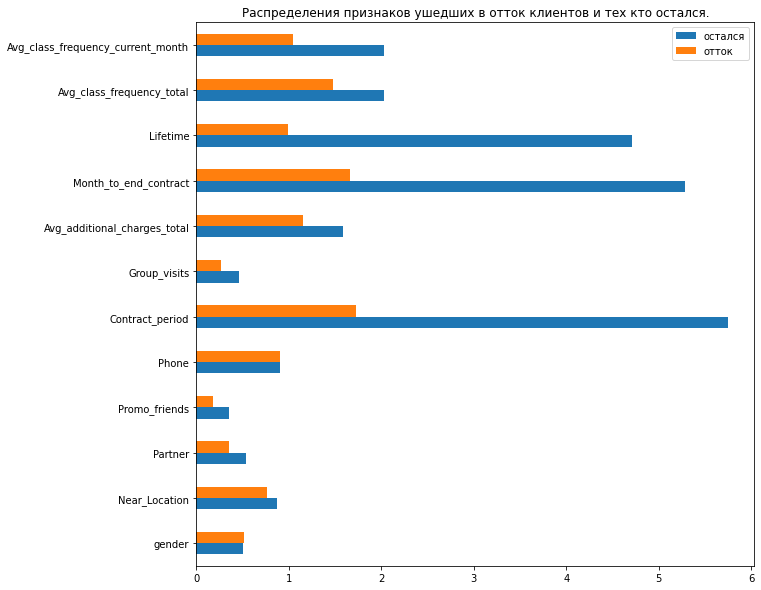

In [10]:
mean_churn_df.plot(kind='barh',figsize=(10, 10))
plt.title('Распределения признаков ушедших в отток клиентов и тех кто остался.')
plt.show()

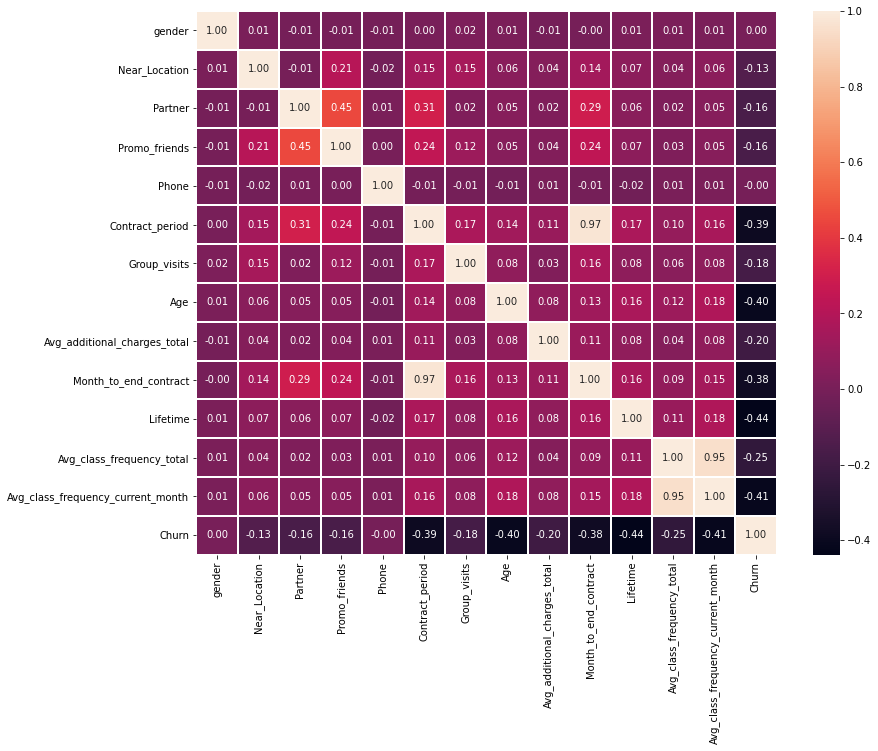

In [11]:
corr = df.corr()
plt.figure(figsize=(13, 10))
sns.heatmap(corr,  annot = True, fmt = '0.2f', linewidths= 1,  )
plt.show()

Можно сделать следующие выводы:
    
- клиенты уходящие в отток имеют низкую среднюю частоту посещений в неделю, и в последний месяц этот показатель снижается. клиенты которые остаются в среднем посещают фитнес-центр 2 раза в неделю.

- клиенты уходящие в отток имеют низкий уровень lifetime, т.е покупка абонимента для них была быстрым и спонтанным решением (менее 1 месяца на обдумывание покупки). Клиенты, которые остаются, основательно подходят к решению о покупке абонимента, средний lifetime 4,7 месяца.

- клиенты уходящие в отток имеют 1,6 мес до конца абонимента.

- у клиентов уходящих в отток - корокие абонименты. ( до 2х месяцев в среднем)

Признаки Month_to_end_contract и Contract_period cильно коррелируют, значения corr 0,97.

Avg_class_frequency_total и Avg_class_frequency_current_month являются схожими показателями и имеют тоже высокий уровень корреляции 0,95.

Возомжно один из пары данных признаков стоит удалить перед обучением модели, так как они линейно-зависимы.


In [12]:
#удалим по одному из пары мультилоллинеарных признаков
df.drop('Avg_class_frequency_current_month', axis = 1, inplace = True)
df.drop('Month_to_end_contract', axis = 1, inplace = True)
df.shape

(4000, 12)

## Модель прогнозирования оттока клиентов.

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

In [13]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df.drop('Churn', axis = 1)
y = df['Churn']

In [14]:
X

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total
0,1,1,1,1,0,6,1,29,0.142275,3,0.020398
1,0,1,0,0,1,12,1,31,1.132029,7,1.922936
2,0,1,1,0,1,1,0,28,1.294485,2,1.859098
3,0,1,1,1,1,12,1,33,0.626699,2,3.205633
4,1,1,1,1,1,1,0,26,1.983623,3,1.113884
...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,0.024060,8,2.284497
3996,0,1,0,0,1,1,1,29,0.688838,1,1.277168
3997,1,1,1,1,1,12,0,28,0.782505,2,2.786146
3998,0,1,1,1,1,6,0,32,0.619127,3,1.630108


Разделим данные на обучающую и валидационную выборку функцией *train_test_split*

In [15]:
# разделим модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

In [16]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [17]:
# Преобразуем обучающие и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модель на train-выборке двумя способами логистической регрессией и случайным лесом.

In [18]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

In [19]:
# зададим алгоритм для модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier (n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

In [20]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

In [21]:
print_all_metrics(y_test, rf_predictions, rf_probabilities, title='Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.89
	Precision: 0.81
	Recall: 0.79


In [22]:
print_all_metrics(y_test, lr_predictions, lr_probabilities, title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.91
	Precision: 0.83
	Recall: 0.83


Оценив метрики accuracy, precision и recall для обеих моделей на валидационной выборке, можно сделать вывод, что модель логистической регрессии имеет лучшие показатели.

## Кластеризация клиентов.

Проведем кластеризацию клиентов.

In [23]:
# обязательная стандартизация данных перед работой с алгоритмами
# обучаем нормализатор и преобразуем набор данных
X_sc = scaler.fit_transform(X)

In [24]:
linked = linkage(X_sc, method = 'ward') 

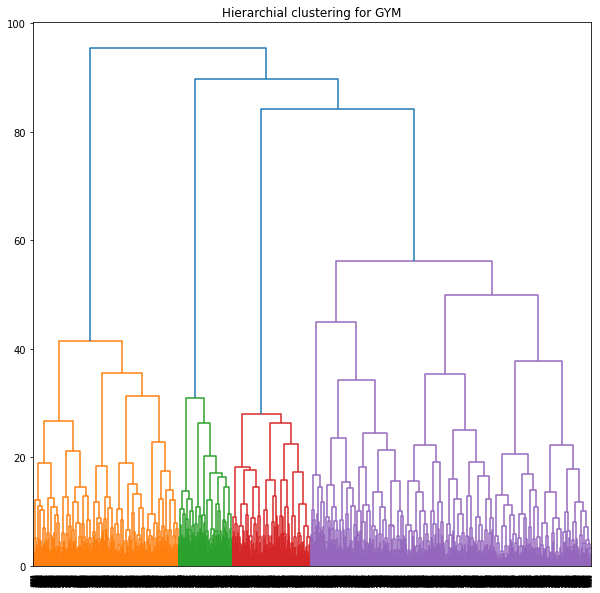

In [25]:
plt.figure(figsize=(10, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

In [26]:
# задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters=5, random_state=0) 
# применяем алгоритм к данным и формируем вектор кластеров
labels = km.fit_predict(X_sc)

In [27]:
# сохраняем метки кластера в поле нашего датасета
df['cluster'] = labels

Посмотрим на средние значения признаков для кластеров.

In [28]:
dfm = df.groupby(['cluster']).mean()
df.groupby(['cluster']).mean().T

cluster,0,1,2,3,4
gender,0.499109,0.488571,0.505300,0.544202,0.523316
Near_Location,0.000000,0.995238,1.000000,1.000000,0.862694
Partner,0.488414,0.955238,0.238516,0.250287,0.471503
Promo_friends,0.076649,0.892381,0.059187,0.079219,0.305699
Phone,1.000000,1.000000,1.000000,1.000000,0.000000
Contract_period,3.032086,7.660952,2.819788,4.528129,4.777202
Group_visits,0.235294,0.458095,0.000000,1.000000,0.427461
Age,28.721925,29.543810,28.770318,29.536165,29.297927
Avg_additional_charges_total,1.375400,1.558614,1.433840,1.480889,1.442082
Lifetime,3.060606,4.380952,3.343640,3.761194,3.940415


Можно сразу заметить что пол и возраст никак не влияют на разбиение по кластерам и долю оттока. На долю оттока и кластеризацию влияют такие признаки, как близость локации, партнерская программа или промо от друга, а также период договора - на сколько месяцев куплен абонимент. Клиенты посещающие групповые тренировки также реже подвержены оттоку. В основном отток происходит у клиентов, которые брали абонимент на короткий период ( 2-3 мес. в среднем), при этом не посещали групповые тренировки и посещали зал реже других клиентов, покупали в среднем меньше дополнительных услуг, чем другие клиенты.

Пострим на графики распределения признаков для кластеров.

<AxesSubplot:xlabel='cluster'>

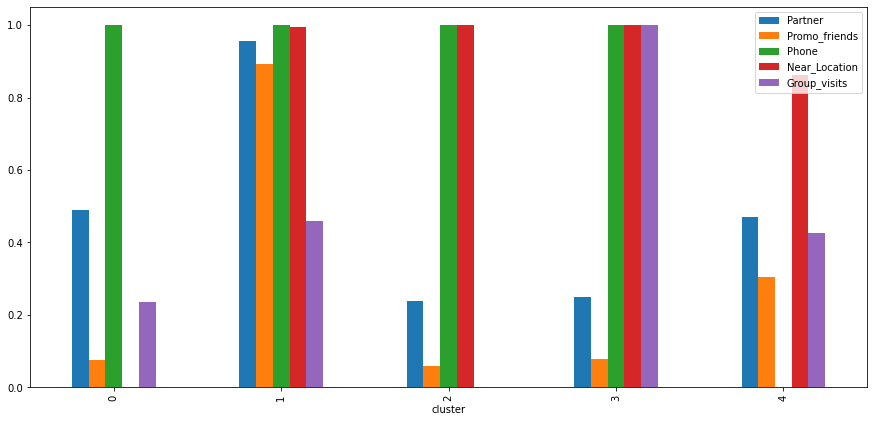

In [29]:
dfm.plot(kind= 'bar', figsize = (15,7), y = ['Partner', 'Promo_friends', 'Phone', 'Near_Location', 'Group_visits'])

In [30]:
# выводим статистику по средним значениям наших признаков по кластеру
df.groupby(['cluster'])['Churn'].mean().sort_values()

cluster
1    0.120952
3    0.200918
4    0.266839
2    0.381625
0    0.399287
Name: Churn, dtype: float64

Первый кластер имеет 12% оттока. Мы можем сказать что это самые стабильные клиенты, которые пришли по партнерской программе (от работы) и  воспользовались промо от друга. Эти клиенты находятся в территориальной близости от зала. Они почти всегда оставляют телефон, и в половине случаев посещают групповые тренировки. Они имеют  самый высокий lifetime свыше 4 мес и наиболее продолжительные абонименты (более 6 мес).

Третий класстер имеет 20% оттока. Это клиенты которые живут рядом, всегда оставляют телефон. Отличительная особенность кластера - это любители групповых тренировкок. У них ниже средний уровень lifetime = 4,5 мес и contract period 3,7 мес

Клиентов четвертого кластера можно вычислить по тому, что они никогда не оставляют свой телефон. У них 26% оттока. Они иногда могут прийти от друга, но чаще нет, в половине случаев возможно от партнерской программы. У них средний уровень lifetime = 4,7 мес и contract period 3,9 мес

Во второй класс вошли клиенты с уровнем оттока 38%. Эти клиенты живут территориально близко, но редко приходят от работы или друга. Они совсем не посещают групповые тренировки. Низкий уровень lifetime 3,3 мес. и непродолжительные абонименты 2,8 мес

Нулевой кластер, это тоже клиенты с самым высоким процентом оттока - 39%. Эти клиенты живут далеко. Near location = 0. В половине случаев они пришли от работы. Они нечасто посещают групповыетренировки. lifetime и contract period примерно равны 3 мес. 

<div class="alert alert-success">
✔️ Очень хорошо и понятно описаны отличительные признаки надежных и ненадежных кластеров

<AxesSubplot:xlabel='cluster'>

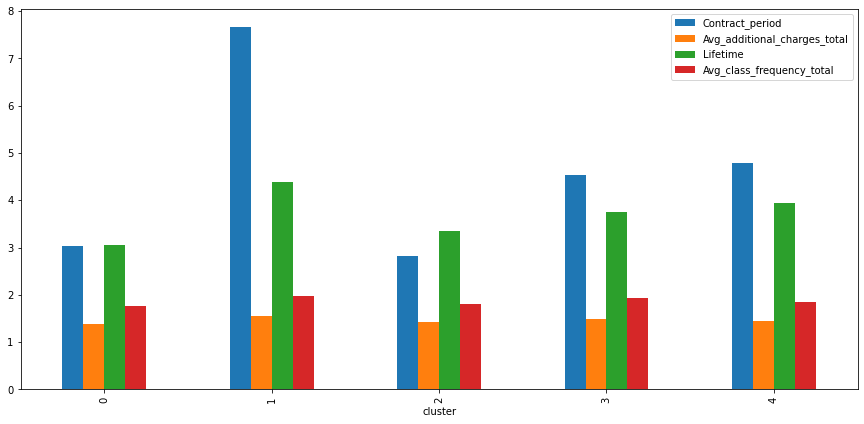

In [31]:
dfm.plot(kind= 'bar', figsize = (15,7), y = ['Contract_period', 'Avg_additional_charges_total', 'Lifetime', 'Avg_class_frequency_total'])

## Выводы и рекомендации по работе с клиентами.

В качестве рекомендации для стратегии взаимодействия с клиентами и их удержания выделим 3-4 важных принципов и примеров их реализации в виде определённых маркетинговых действий.

- Привлечение новых клиентов по партнерской программе  и программе приведи друга в районе расположения фитнес-центра.

- Маркетинговые и рекламные мероприятия направленные на увеличение срока контракта (покупку годовых абониментов).

- Повышение вовлеченности к посещению фитнес-центра и групповых программ, поощрение посещения (особенно важно для 3 кластера), достижение и поддержание у клиентов уровня Avg_class_frequency_total >2 